# makemore 2
Following a tutorial from [Andrej Karpathy](https://karpathy.ai/):
- [The spelled-out intro to language modeling: Building makemore Part 2: MLP](https://youtu.be/TCH_1BHY58I?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

Implement MultiLayer Perceptron (MLP) character-level language model. Given a N-gram of characters, predict the next character. 

# Setup

In [ ]:
# !pip install torch matplotlib graphviz

# Load the data

In [1]:
words = open('names.txt', 'r').read().splitlines()

# Implement the model

In [186]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [3]:
# build the vocabulary and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [133]:
# build the training set
block_size = 3 # the N-gram context size
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(f'given context: {"".join(itos[i] for i in context)} expected next char: {itos[ix]}')
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

## Working through the model

In [33]:
# Embedding layer:
# cram the data (vocabulary) into a 2 dimentional space
C = torch.randn((len(stoi), 2))

In [ ]:
# One way to compute the embeddings for the vocab element 5 is to do a matrix multiplication of the one-hot vector for 5 with the embedding matrix C:
inp = F.one_hot(torch.tensor(5), num_classes=len(itos)).float()
print(f'{inp @ C=}')
# this if equivallent to retrieving the row 5 from the embedding matrix
print(f'{C[5]=}')

# there is synthactic sugar to retrieve multiple rows at once
print(f'{C[[1, 2, 3]]=}')
# or even compute the embeddings for entire matrices
print(f'{C[X]=}')

# because X[13, 2] == 1
print(f'{torch.equal(C[X][13, 2], C[1])=}')


In [48]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [71]:
# 6 because we have 3 embeddings (we use N-grams of size N=3) and each embedding is 2 dimentional
# 100 is the (arbitrary) size of the hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

# juggle with dimensions
# print(f'{emb.shape=}')
# print(f'{emb.view(32, 6).shape=}')

h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [ ]:
# create the output layer
W2 = torch.randn((100, len(itos)))
b2 = torch.randn(len(itos))

logits = h @ W2 + b2

# compute the loss
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(len(X)), Y].log().mean()
print(f'{loss=}')

# which is equivallent to
loss2 = F.cross_entropy(logits, Y)
print(f'{loss2=}')

## Refactored model

In [175]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(stoi), 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, len(itos)), generator=g)
b2 = torch.randn(len(itos), generator=g)
parameters = [C, W1, b1, W2, b2]

In [190]:
for p in parameters:
    p.requires_grad = True

In [135]:
# hyperparameters
learning_rate = 0.1
epoch = 100

In [ ]:
for _ in range(epoch):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f'{loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

## Train in mini-batches
Before we trained on the entire dataset at each epoch, now let's generate random mini batches and train faster

In [140]:
# hyperparameters
learning_rate = 0.1
epoch = 100
batch_size = 32

In [156]:
for _ in range(epoch):
    # minibatch
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(f'{loss.item()=}')
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

loss.item()=2.491424083709717


In [157]:
# evaluate the model on the entire dataset
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f'{loss=}')

loss=tensor(2.5878, grad_fn=<NllLossBackward0>)


## Guesstimate the best learning rate
We try to learn with a bunch of learning rate plot the loss, and chose the sweet spot

In [165]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
epoch = 1000
lri, lossi = [], []

for i in range(epoch):
    # minibatch
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(f'{loss.item()=}')
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

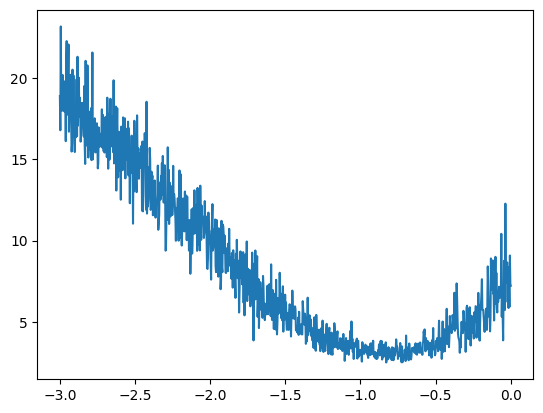

In [178]:
plt.plot(lri, lossi)

The sweet spot seems around $10^{-1} = 0.1$

## Use our found learning rate to train more
We can also incomporate a learning rate decay. After the training start to plateau we reduce the learning rate of one order of magnitude and run more training.

In [ ]:
epoch = 10000
lr = 0.1

for i in range(epoch):
    # minibatch
    ix = torch.randint(0, X.shape[0], (batch_size,))

    # forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(f'{loss.item()=}')
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update the parameters
    for p in parameters:
        p.data -= lr * p.grad


In [185]:
# evaluate the model on the entire dataset
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(f'{loss=}')

loss=tensor(2.3166, grad_fn=<NllLossBackward0>)


## More rigor
Right now we use all our dataset for training. We have no way to know how much we are overfitting the data. A good practice would be to split our dataset into three:
- ~80% training (used to train the parameters)
- ~10% dev/validation (used to train the hyperparameters)
- ~10% test (used to validate the performance at the very end, this has to stay pure, it should be used as few as possible)

In [187]:
# build the dataset splits
block_size = 3 # the N-gram context size

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [191]:
# instantiate the model
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(stoi), 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, len(itos)), generator=g)
b2 = torch.randn(len(itos), generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
# hyper params
batch_size = 32
epoch = 10000
n_epoch = 10
lr = 0.1

# train
for t in range(n_epoch):
    if t == n_epoch - 1: lr /= 10 # learning rate decay
    for i in range(epoch):
        # minibatch
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))

        # forward pass
        emb = C[Xtr[ix]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update the parameters
        for p in parameters:
            p.data -= lr * p.grad
    print(f'{loss.item()=}')


In [200]:
# evaluate the model on the training split
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f'{loss=}')

loss=tensor(2.2266, grad_fn=<NllLossBackward0>)


In [201]:
# evaluate the model on the validation split
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f'{loss=}')

loss=tensor(2.2344, grad_fn=<NllLossBackward0>)


## Extra considerations
The NN doesn't seem to be very much overfitting the data ($loss_{Xtr} \approx loss_{Xdev}$) meaning it is underfitting the data. It can have several causes:
- The hidden layers are probably too small, we could get better performances by increasing the number of weights.
- The embedding space has too few dimensions (i.e. we only used 2-dimensional embeddings).
- It could also mean that we are using too small of a minibatch. Making the data too noisy for the gradient computation to converge.

## Visualize the embeddings

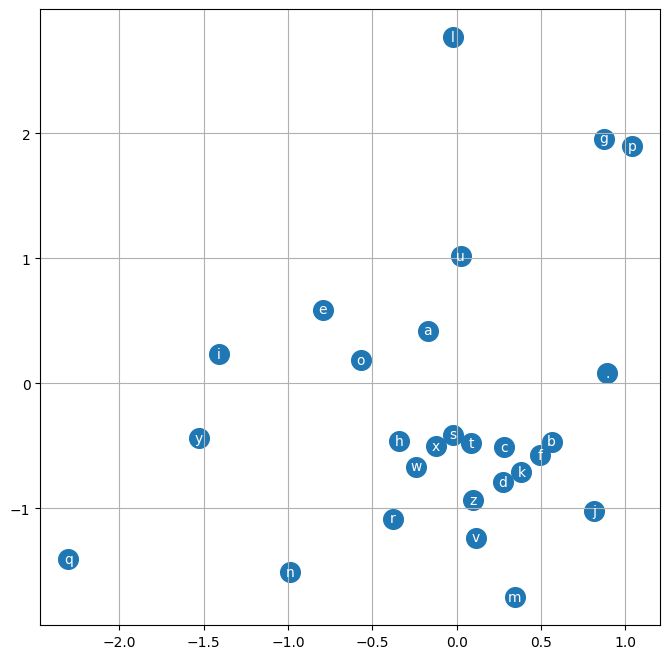

In [202]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

## Scale up the embedding space and hidden layer

In [204]:
# instantiate the model
emb_dim = 10
hidden_dim = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(stoi), emb_dim), generator=g)
W1 = torch.randn((emb_dim * 3, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim, len(itos)), generator=g)
b2 = torch.randn(len(itos), generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [209]:
# metrics
lossi, stepi = [], []

In [ ]:
# hyper params
batch_size = 32
epoch = 10000
n_epoch = 10
lr = 0.1

# train
for t in range(n_epoch):
    if t == n_epoch - 1: lr /= 10 # learning rate decay
    for i in range(epoch):
        # minibatch
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))

        # forward pass
        emb = C[Xtr[ix]]
        h = torch.tanh(emb.view(-1, emb_dim * 3) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
        
        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update the parameters
        for p in parameters:
            p.data -= lr * p.grad

        # metrics
        stepi.append(epoch * t + i)
        lossi.append(loss.log10().item())
    print(f'{loss.item()=}')


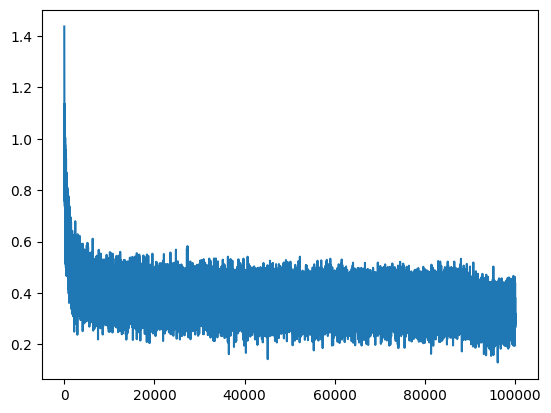

In [211]:
# print a log scale plot of the loss
plt.plot(stepi, lossi)

In [215]:
# evaluate the model on the training split
emb = C[Xtr]
h = torch.tanh(emb.view(-1, emb_dim * 3) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f'{loss=}')

loss=tensor(2.1344, grad_fn=<NllLossBackward0>)


In [216]:
# evaluate the model on the validation split
emb = C[Xdev]
h = torch.tanh(emb.view(-1, emb_dim * 3) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f'{loss=}')

loss=tensor(2.1699, grad_fn=<NllLossBackward0>)


## Run the model for fun

In [217]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: break
    
    print(''.join(itos[i] for i in out))

junide.
jakariz.
paliah.
adin.
kailetto.
sabe.
tem.
kalinaauyanilena.
jededainm.
imelysson.
evy.
arthousteum.
kyfontume.
ponteliah.
jaylynora.
yae.
ocklynn.
brine.
kolin.
wyn.
